In [1]:
import pandas as pd
import numpy as np

In [2]:
# SIPRI Dataset (Main Dataset): The SIPRI Military Expenditure Database contains consistent time series on the military spending of countries for the period 1949–2024. The database is updated annually, which may include updates to data for any of the years included in the database. 

raw = pd.read_excel(r"D:\Downloads\SIPRI-Milex-data-1949-2025.xlsx", sheet_name="Constant (2023) US$",header=None)

C:\Users\achar\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
raw.shape

(199, 79)

In [4]:
# 2. Find header row where first column == "Country"
header_row_idx = raw.index[raw.iloc[:, 0] == "Country"][0]
header_row = raw.iloc[header_row_idx]

# 3. Build year column indices (must be number AND not NaN)
year_col_indices = [
    i for i, v in enumerate(header_row)
    if isinstance(v, (int, float)) and not pd.isna(v)
]

# 4. Data starts after header row
data_start_idx = header_row_idx + 1

# 5. Subset: Country + year columns
country_col_idx = 0
df = raw.iloc[data_start_idx:, [country_col_idx] + year_col_indices].copy()

# 6. Create column labels
year_labels = [int(header_row[i]) for i in year_col_indices]
df.columns = ["Country"] + year_labels

# 7. Drop rows without country name
df = df[df["Country"].notna()]

# 8. Replace SIPRI placeholders
df = df.replace(["..", "xxx"], pd.NA)

# 9. Convert year columns to numeric
for col in year_labels:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 10. Drop region headers
df = df.dropna(subset=year_labels, how="all")

# 11. Melt to long format (final dataset)
df_long = df.melt(
    id_vars="Country",
    value_vars=year_labels,
    var_name="Year",
    value_name="Spending"
)

# 12. Type cast
df_long["Year"] = df_long["Year"].astype(int)

print(df_long.head())
print(df_long.shape)


   Country  Year  Spending
0  Algeria  1949       NaN
1    Libya  1949       NaN
2  Morocco  1949       NaN
3  Tunisia  1949       NaN
4   Angola  1949       NaN
(12768, 3)


In [5]:
df_long

,Country,Year,Spending
0,Algeria,1949,NaN
1,Libya,1949,NaN
2,Morocco,1949,NaN
3,Tunisia,1949,NaN
4,Angola,1949,NaN
...,...,...,...
12763,Saudi Arabia,2024,78953.627231
12764,Türkiye,2024,21884.408731
12765,United Arab Emirates,2024,NaN
12766,"Yemen, North",2024,NaN


In [6]:
# 4.1 Filter relevant countries and years :

countries = [
    "United States of America",
    "China",
    "India",
    "Russia",
    "Pakistan"
]

df_main = df_long[
    (df_long["Country"].isin(countries)) &
    (df_long["Year"] >= 2000)
].copy()

df_main.head()


,Country,Year,Spending
8630,United States of America,2000,566381.009236
8648,India,2000,31036.356721
8650,Pakistan,2000,4500.604320
8652,China,2000,42518.976239
8697,Russia,2000,23790.006666


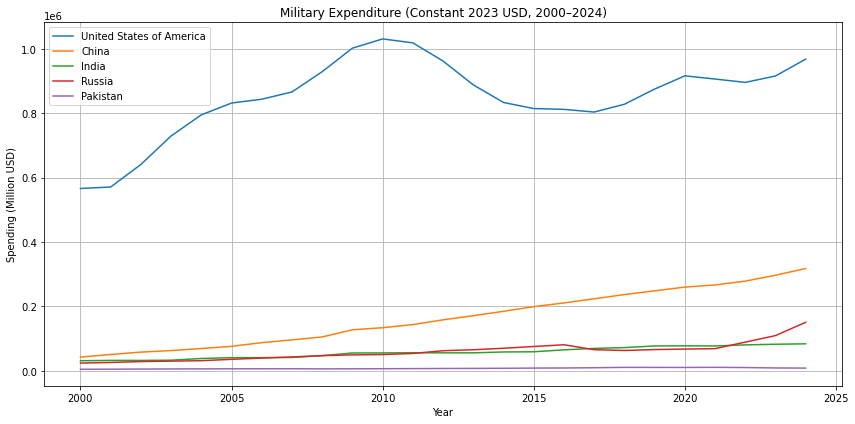

In [7]:
# Trend line: Military spending 2000–2024 :

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for c in countries:
    sub = df_main[df_main["Country"] == c]
    plt.plot(sub["Year"], sub["Spending"], label=c)

plt.title("Military Expenditure (Constant 2023 USD, 2000–2024)")
plt.xlabel("Year")
plt.ylabel("Spending (Million USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


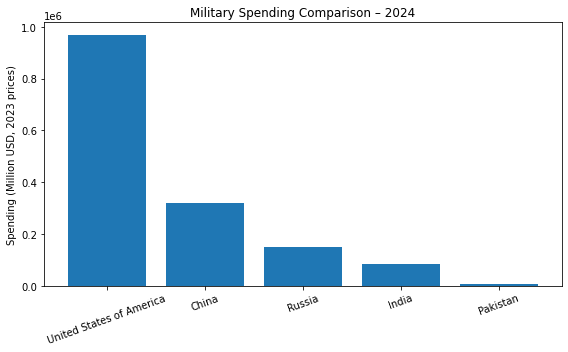

In [8]:
# Bar chart: Latest year comparison (say 2024 or 2023) :

latest_year = df_main["Year"].max()

df_latest = (
    df_main[df_main["Year"] == latest_year]
    .sort_values("Spending", ascending=False)
)

plt.figure(figsize=(8, 5))
plt.bar(df_latest["Country"], df_latest["Spending"])
plt.title(f"Military Spending Comparison – {latest_year}")
plt.ylabel("Spending (Million USD, 2023 prices)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


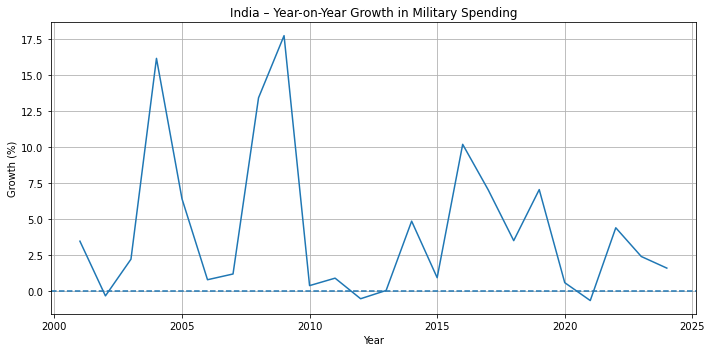

In [9]:
# India’s growth rate over time :

india = df_main[df_main["Country"] == "India"].sort_values("Year").copy()
india["YoY_Growth_%"] = india["Spending"].pct_change() * 100

plt.figure(figsize=(10, 5))
plt.plot(india["Year"], india["YoY_Growth_%"])
plt.axhline(0, linestyle="--")
plt.title("India – Year-on-Year Growth in Military Spending")
plt.xlabel("Year")
plt.ylabel("Growth (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


### **% of GDP data (second SIPRI sheet)** 

In [10]:
# Clean the Share-of-GDP sheet
raw_gdp = pd.read_excel(r"D:\Downloads\SIPRI-Milex-data-1949-2025.xlsx", sheet_name="Share of GDP",header=None)

C:\Users\achar\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [11]:
raw_gdp

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,Military expenditure by country as percentage ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Countries are grouped by region and subregion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Figures in blue are SIPRI estimates. Figures i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,""". ."" = data unavailable. ""xxx"" = country did ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,Syria,§,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Türkiye,‖,...,...,...,...,...,...,...,...,...,0.018128,0.020503,0.020501,0.025221,0.026899,0.021956,0.018589,0.016588,0.017199,0.019226
196,United Arab Emirates,§98,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,"Yemen, North",§100,...,...,...,...,...,...,...,...,...,xxx,xxx,xxx,xxx,xxx,xxx,xxx,xxx,xxx,xxx


In [12]:
# header row
header_row_idx_g = raw_gdp.index[raw_gdp.iloc[:, 0] == "Country"][0]
header_row_g = raw_gdp.iloc[header_row_idx_g]

# year columns (again numeric & not NaN)
year_col_indices_g = [
    i for i, v in enumerate(header_row_g)
    if isinstance(v, (int, float)) and not pd.isna(v)
]

data_start_idx_g = header_row_idx_g + 1
country_col_idx_g = 0

df_gdp = raw_gdp.iloc[data_start_idx_g:, [country_col_idx_g] + year_col_indices_g].copy()

year_labels_g = [int(header_row_g[i]) for i in year_col_indices_g]
df_gdp.columns = ["Country"] + year_labels_g

df_gdp = df_gdp[df_gdp["Country"].notna()]
df_gdp = df_gdp.replace(["..", "xxx"], pd.NA)

for col in year_labels_g:
    df_gdp[col] = pd.to_numeric(df_gdp[col], errors="coerce")

df_gdp = df_gdp.dropna(subset=year_labels_g, how="all")

# long format
gdp_long = df_gdp.melt(
    id_vars="Country",
    value_vars=year_labels_g,
    var_name="Year",
    value_name="GDP_Share"
)
gdp_long["Year"] = gdp_long["Year"].astype(int)

In [13]:
gdp_long

,Country,Year,GDP_Share
0,Algeria,1949,NaN
1,Libya,1949,NaN
2,Morocco,1949,NaN
3,Tunisia,1949,NaN
4,Angola,1949,NaN
...,...,...,...
12611,Saudi Arabia,2024,0.072981
12612,Syria,2024,NaN
12613,Türkiye,2024,0.019226
12614,United Arab Emirates,2024,NaN


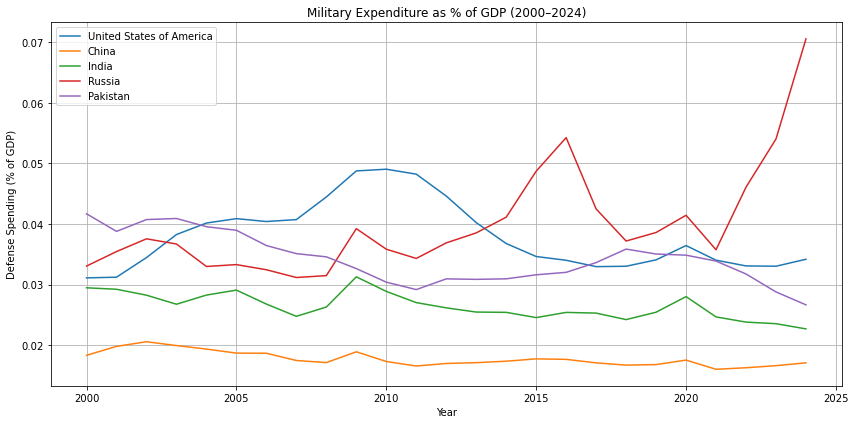

In [14]:
# Compare defense burden (% of GDP) :

gdp_main = gdp_long[
    (gdp_long["Country"].isin(countries)) &
    (gdp_long["Year"] >= 2000)
].copy()

plt.figure(figsize=(12, 6))
for c in countries:
    sub = gdp_main[gdp_main["Country"] == c]
    plt.plot(sub["Year"], sub["GDP_Share"], label=c)

plt.title("Military Expenditure as % of GDP (2000–2024)")
plt.xlabel("Year")
plt.ylabel("Defense Spending (% of GDP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Threat & technology tables (quick but effective) :

tech_data = {
    "Country": ["United States of America", "China", "Russia", "India", "Pakistan"],
    "AI_Capability": ["Very High", "High", "High", "Medium", "Low"],
    "Cyber_Warfare": ["Very High", "High", "High", "Medium", "Low"],
    "Drone_Tech": ["Very High", "High", "Medium", "Medium", "Low-Medium"],
    "Space_Warfare": ["Very High", "High", "Medium", "Growing", "Low"]
}

df_tech = pd.DataFrame(tech_data)
df_tech


,Country,AI_Capability,Cyber_Warfare,Drone_Tech,Space_Warfare
0,United States of America,Very High,Very High,Very High,Very High
1,China,High,High,High,High
2,Russia,High,High,Medium,Medium
3,India,Medium,Medium,Medium,Growing
4,Pakistan,Low,Low,Low-Medium,Low


### Calculate 10-year CAGR (Compound Annual Growth Rate)

In [16]:
import numpy as np

def cagr(first, last, years):
    return (last / first) ** (1 / years) - 1

cagr_data = []

latest_year = df_main["Year"].max()
start_year = latest_year - 10

for c in countries:
    sub = df_main[(df_main["Country"] == c) & (df_main["Year"].isin([start_year, latest_year]))]
    
    if len(sub) == 2:
        start = sub[sub["Year"] == start_year]["Spending"].values[0]
        end = sub[sub["Year"] == latest_year]["Spending"].values[0]
        growth = cagr(start, end, 10)
        cagr_data.append([c, growth * 100])

df_cagr = pd.DataFrame(cagr_data, columns=["Country", "CAGR_%"])
df_cagr


,Country,CAGR_%
0,United States of America,1.508003
1,China,5.570233
2,India,3.668553
3,Russia,7.978432
4,Pakistan,0.764667


In [17]:
# Combine absolute spending, GDP% and CAGR into one table :

# Extract latest-year absolute spending
df_latest = df_main[df_main["Year"] == latest_year][["Country", "Spending"]]

# Extract latest-year GDP share
gdp_latest = gdp_main[gdp_main["Year"] == latest_year][["Country", "GDP_Share"]]

# Merge all three datasets
threat_df = df_latest.merge(gdp_latest, on="Country").merge(df_cagr, on="Country")

threat_df


,Country,Spending,GDP_Share,CAGR_%
0,United States of America,968381.594851,0.034192,1.508003
1,India,83623.140581,0.022712,3.668553
2,Pakistan,8183.350599,0.026676,0.764667
3,China,317561.042325,0.017113,5.570233
4,Russia,150533.996752,0.070523,7.978432


### Rank countries by threat score :

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

threat_scaled = scaler.fit_transform(
    threat_df[["Spending", "GDP_Share", "CAGR_%"]]
)

threat_df["Threat_Score"] = threat_scaled.sum(axis=1)
threat_df.sort_values("Threat_Score", ascending=False)


,Country,Spending,GDP_Share,CAGR_%,Threat_Score
4,Russia,150533.996752,0.070523,7.978432,2.148251
0,United States of America,968381.594851,0.034192,1.508003,1.422817
3,China,317561.042325,0.017113,5.570233,0.988368
1,India,83623.140581,0.022712,3.668553,0.585946
2,Pakistan,8183.350599,0.026676,0.764667,0.179048


## Military technology positioning :

### Technology score table :

In [19]:
tech_data = {
    "Country": countries,
    "AI": [5, 4, 4, 3, 2],
    "Cyber": [5, 4, 4, 3, 2],
    "Drones": [5, 4, 3, 3, 2],
    "Space": [5, 4, 3, 3, 1]
}

tech_df = pd.DataFrame(tech_data)
tech_df


,Country,AI,Cyber,Drones,Space
0,United States of America,5,5,5,5
1,China,4,4,4,4
2,India,4,4,3,3
3,Russia,3,3,3,3
4,Pakistan,2,2,2,1


### Visualize tech comparison :

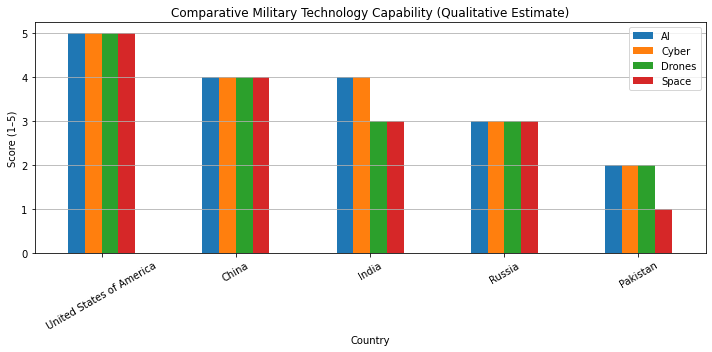

In [20]:
tech_df.set_index("Country").plot(kind="bar", figsize=(10,5))
plt.title("Comparative Military Technology Capability (Qualitative Estimate)")
plt.ylabel("Score (1–5)")
plt.xticks(rotation=30)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


# India Defence Budget Dataset (core India-specific data)

In [21]:
# Load and clean this dataset

import pandas as pd

budget_df = pd.read_excel(r"D:\Downloads\india_defence_budget.xlsx")

budget_df.head()


,Year,Total_Budget_INR_cr,Capital_Expenditure_INR_cr,Revenue_Expenditure_INR_cr,RnD_DRDO_INR_cr,Domestic_Procurement_Share_pct,Defence_Exports_USD_m
0,2014,229000,79000,150000,10000,50,1500
1,2015,246727,86200,160527,11000,55,1800
2,2016,249099,85600,163499,12000,58,2000
3,2017,262390,87400,175000,14000,60,2500
4,2018,282733,93982,188752,15000,62,2500


### (a) Total budget trend :

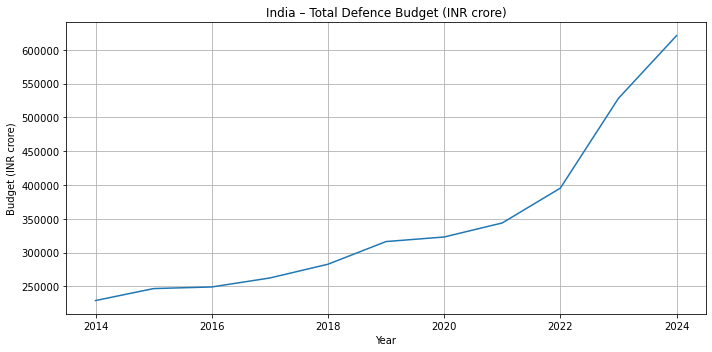

In [22]:
# Visualize India’s budget structure :

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(budget_df["Year"], budget_df["Total_Budget_INR_cr"])
plt.title("India – Total Defence Budget (INR crore)")
plt.xlabel("Year")
plt.ylabel("Budget (INR crore)")
plt.grid(True)
plt.tight_layout()
plt.show()


### (b) Capital vs Revenue :

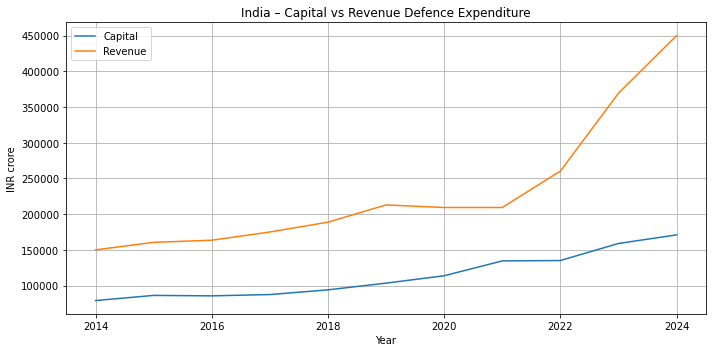

In [23]:
plt.figure(figsize=(10,5))
plt.plot(budget_df["Year"], budget_df["Capital_Expenditure_INR_cr"], label="Capital")
plt.plot(budget_df["Year"], budget_df["Revenue_Expenditure_INR_cr"], label="Revenue")
plt.title("India – Capital vs Revenue Defence Expenditure")
plt.xlabel("Year")
plt.ylabel("INR crore")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Capital share (% of budget) :

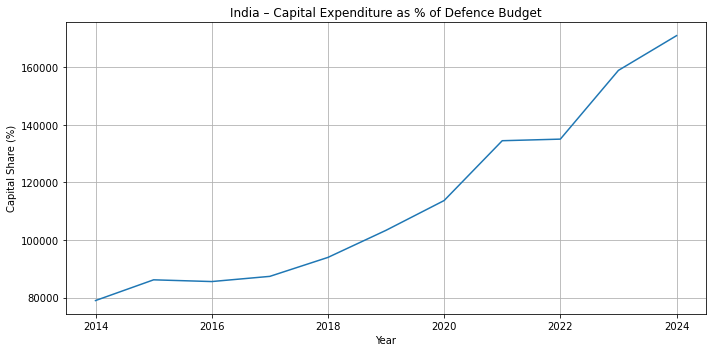

In [24]:
plt.figure(figsize=(10,5))
plt.plot(budget_df["Year"], budget_df["Capital_Expenditure_INR_cr"])
plt.title("India – Capital Expenditure as % of Defence Budget")
plt.xlabel("Year")
plt.ylabel("Capital Share (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


## R&D intensity

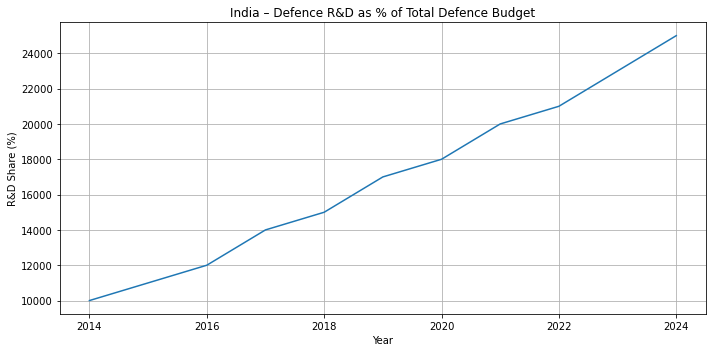

In [25]:
plt.figure(figsize=(10,5))
plt.plot(budget_df["Year"], budget_df["RnD_DRDO_INR_cr"])
plt.title("India – Defence R&D as % of Total Defence Budget")
plt.xlabel("Year")
plt.ylabel("R&D Share (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Defence Manufacturing / Make in India

In [26]:
# Load and clean this dataset

import pandas as pd

mfg = pd.read_excel(r"D:\Downloads\india_defence_manufacturing.xlsx")

mfg.head()


,Year,Domestic_Production_Value_INR_cr,Import_Dependence_pct,Domestic_Procurement_Share_pct,Defence_Exports_USD_m
0,2014,50000,60,40,1500
1,2015,52000,58,42,1700
2,2016,54000,56,44,1900
3,2017,58000,54,46,2100
4,2018,62000,52,48,2300


In [27]:
mfg["Year"] = mfg["Year"].astype(int)
mfg.sort_values("Year", inplace=True)

In [28]:
mfg

,Year,Domestic_Production_Value_INR_cr,Import_Dependence_pct,Domestic_Procurement_Share_pct,Defence_Exports_USD_m
0,2014,50000,60,40,1500
1,2015,52000,58,42,1700
2,2016,54000,56,44,1900
3,2017,58000,54,46,2100
4,2018,62000,52,48,2300
5,2019,70000,50,50,2500
6,2020,78000,48,52,2800
7,2021,86000,45,55,3200
8,2022,95000,42,58,3600
9,2023,115000,40,60,5200


### (a) Domestic production growth :

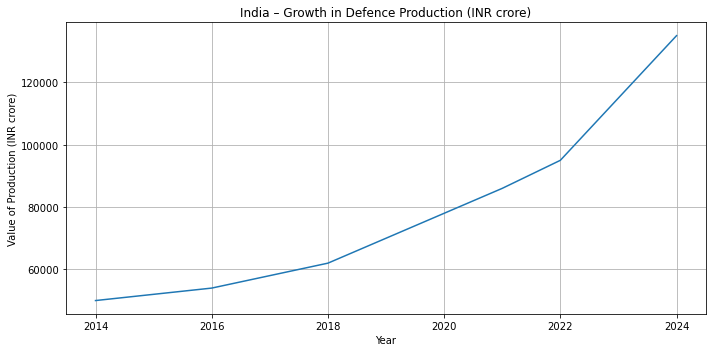

In [29]:
plt.figure(figsize=(10,5))
plt.plot(mfg["Year"], mfg["Domestic_Production_Value_INR_cr"])
plt.title("India – Growth in Defence Production (INR crore)")
plt.xlabel("Year")
plt.ylabel("Value of Production (INR crore)")
plt.grid(True)
plt.tight_layout()
plt.show()


### (b) Import dependence vs domestic share

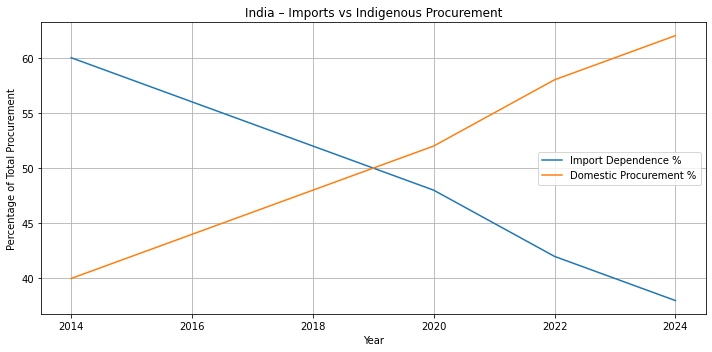

In [30]:
plt.figure(figsize=(10,5))
plt.plot(mfg["Year"], mfg["Import_Dependence_pct"], label="Import Dependence %")
plt.plot(mfg["Year"], mfg["Domestic_Procurement_Share_pct"], label="Domestic Procurement %")
plt.title("India – Imports vs Indigenous Procurement")
plt.xlabel("Year")
plt.ylabel("Percentage of Total Procurement")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### (c) Defence exports

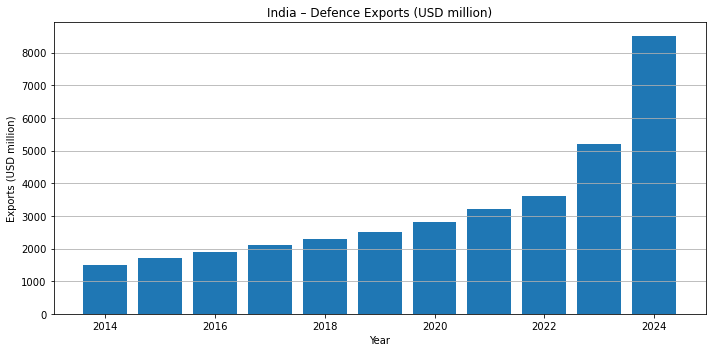

In [31]:
plt.figure(figsize=(10,5))
plt.bar(mfg["Year"], mfg["Defence_Exports_USD_m"])
plt.title("India – Defence Exports (USD million)")
plt.xlabel("Year")
plt.ylabel("Exports (USD million)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


# Tie India-specific data back to global SIPRI trends

In [32]:
# From earlier: df_main has India SIPRI data in USD
india_sipri = df_main[df_main["Country"] == "India"][["Year", "Spending"]]

india_compare = budget_df.merge(india_sipri, on="Year", how="inner")
india_compare.head()


,Year,Total_Budget_INR_cr,Capital_Expenditure_INR_cr,Revenue_Expenditure_INR_cr,RnD_DRDO_INR_cr,Domestic_Procurement_Share_pct,Defence_Exports_USD_m,Spending
0,2014,229000,79000,150000,10000,50,1500,58325.181861
1,2015,246727,86200,160527,11000,55,1800,58879.314336
2,2016,249099,85600,163499,12000,58,2000,64884.247012
3,2017,262390,87400,175000,14000,60,2500,69454.960311
4,2018,282733,93982,188752,15000,62,2500,71900.845425


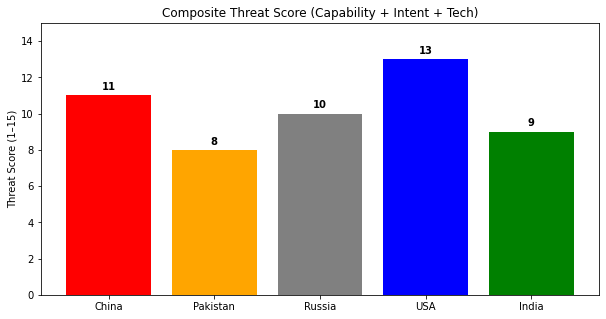

In [33]:
import matplotlib.pyplot as plt

countries = ['China', 'Pakistan', 'Russia', 'USA', 'India']
scores = [11, 8, 10, 13, 9]

plt.figure(figsize=(10,5))
plt.bar(countries, scores, color=['red','orange','gray','blue','green'])

plt.title('Composite Threat Score (Capability + Intent + Tech)')
plt.ylabel('Threat Score (1–15)')
plt.ylim(0,15)

for i, v in enumerate(scores):
    plt.text(i, v+0.3, str(v), ha='center', fontweight='bold')

plt.show()
